In [1]:
import glacierml as gl
import pandas as pd

2023-05-15 18:05:42.526110: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-15 18:05:42.570014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 18:05:43.245370: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = gl.load_notebook_data(parameterization = '4') # 0.75 threshold

glac = gl.load_training_data(RGI_input = 'y')
glac = glac[['RGIId', 'Thickness']]
df_g = pd.merge(df, glac, on = 'RGIId', how = 'inner')
df_g

,RGIId,Mean Thickness,Median Thickness,Thickness Std Dev,Weighted Mean Thickness,Residual Correction,Residual Variance,Bootstrap Uncertainty,Composite Deviation Uncertainty,Composite Deviation Uncertainty 3,...,Aspect,Lmax,Farinotti Mean Thickness,Farinotti Shapiro-Wilk statistic,Farinotti Shapiro-Wilk p_value,Farinotti Median Thickness,Farinotti Thickness STD,Farinotti Skew,Farinotti Volume (km3),Thickness
0,RGI60-01.00037,209.310257,216.130905,40.039093,208.571265,-94.797246,0.118873,0.080467,43.391821,2219.381482,...,30,41911,221.368740,0.894585,0.000000e+00,174.291930,53.527866,0.780877,51.929343,235.0
1,RGI60-01.00570,90.494202,91.317276,15.268613,90.268711,-23.045132,0.007220,0.015211,8.210264,424.174276,...,172,8639,75.656790,0.939484,0.000000e+00,67.445496,18.147484,0.752189,1.329063,147.0
2,RGI60-01.01104,90.167320,91.284256,15.082670,89.925246,-22.710686,0.007064,0.015024,8.142304,412.393305,...,327,6332,110.901680,0.944506,0.000000e+00,97.632590,29.573280,0.806189,1.056671,66.0
3,RGI60-01.02236,51.709263,50.033535,13.439234,51.614080,-0.005361,-0.000051,0.012848,2.674014,132.600786,...,219,680,22.385798,0.970167,4.969998e-05,24.184961,1.360460,-0.282476,0.003425,83.0
4,RGI60-01.02236,51.709263,50.033535,13.439234,51.614080,-0.005361,-0.000051,0.012848,2.674014,132.600786,...,219,680,22.385798,0.970167,4.969998e-05,24.184961,1.360460,-0.282476,0.003425,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,RGI60-19.01012,107.371895,110.740059,15.851901,107.120721,-33.559400,0.015259,0.013589,11.535520,625.097677,...,-9,318,15.617301,0.989473,1.451944e-02,15.721304,0.932892,0.161842,0.003326,312.0
496,RGI60-19.01950,97.799950,101.289764,12.548057,97.609065,-27.974227,0.010444,0.007735,9.607995,521.614170,...,150,5187,398.524960,0.950762,0.000000e+00,347.143980,49.511383,0.124630,2.885321,238.0
497,RGI60-19.02058,79.080803,81.504219,8.664020,78.950951,-15.760741,0.003423,0.003993,6.295792,342.921253,...,260,1118,79.968520,0.769153,2.802597e-45,64.821260,25.859463,2.136447,0.092763,89.0
498,RGI60-19.02059,91.311539,94.843819,10.899248,91.142168,-23.815412,0.007603,0.005572,8.382532,454.454628,...,273,3056,224.429600,0.983205,6.195902e-31,224.896590,30.958113,0.355534,1.232792,97.0


In [12]:
import numpy as np

thickness_true = df_g['Thickness']
thickness_estimates = df_g['Weighted Mean Thickness']
thickness_uncertainty_estimates = np.abs(thickness_true - thickness_estimates)

labels = thickness_true
predictions = thickness_estimates
uncertainties = thickness_uncertainty_estimates

# Make splits (we wont randomly split because we will use Glathida/non-Glathida)
n = 100 # number of calibration points
idx = np.array([1] * n + [0] * (labels.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_labels, val_labels = labels[idx], labels[~idx]
cal_pred,   val_pred   = predictions[idx], predictions[~idx]
cal_unc,    val_unc    = uncertainties[idx], uncertainties[~idx]

def conformal_prediction(cal_labels,cal_pred,cal_unc, alpha = .05):

    # Get scores
    cal_scores = np.abs(cal_pred - cal_labels)/cal_labels

    # Get the score quantile
    qhat = np.quantile(cal_scores, ((n+1)*(1-alpha))/n, interpolation='higher')
    
    return qhat

qhat = conformal_prediction(
    cal_labels,
    cal_pred,
    cal_unc
)

# Deploy (output=lower and upper adjusted quantiles)
prediction_sets = [val_pred - val_unc*qhat, val_pred + val_unc*qhat ]




In [15]:
val_unc

1       56.731289
2       23.925246
4       30.385920
7        6.802799
8        1.835971
          ...    
492      8.825504
494      0.823822
495    204.879279
496    140.390935
499    143.802250
Length: 400, dtype: float64

In [16]:
val_labels

1      147.0
2       66.0
4       82.0
7       72.0
8       66.0
       ...  
492     67.0
494    100.0
495    312.0
496    238.0
499    265.0
Name: Thickness, Length: 400, dtype: float64

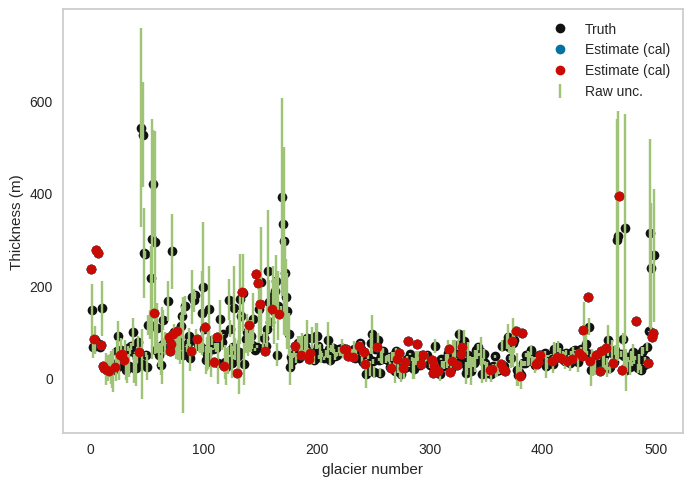

In [13]:
import matplotlib.pyplot as plt
plt.subplots()

plt.plot(thickness_true,'ok',label='Truth')
plt.plot(cal_labels,'o',label='Estimate (cal)')
# plt.errorbar(np.arange(n_total)[idx],
#              cal_labels,
#              yerr=cal_unc*qhat,
#              ls='none',label='CP')
plt.errorbar(
    np.arange(n_total)[~idx],
    val_labels,
    yerr=val_unc,
    ls='none',
    label='Raw unc.'
)
plt.plot(cal_labels,'o',label='Estimate (cal)')

# plt.plot(np.arange(n_total)[~idx],val_pred,'o',label='Estimate (val)')
plt.xlabel('glacier number')
plt.ylabel('Thickness (m)')
plt.legend()
plt.grid()
plt.show()

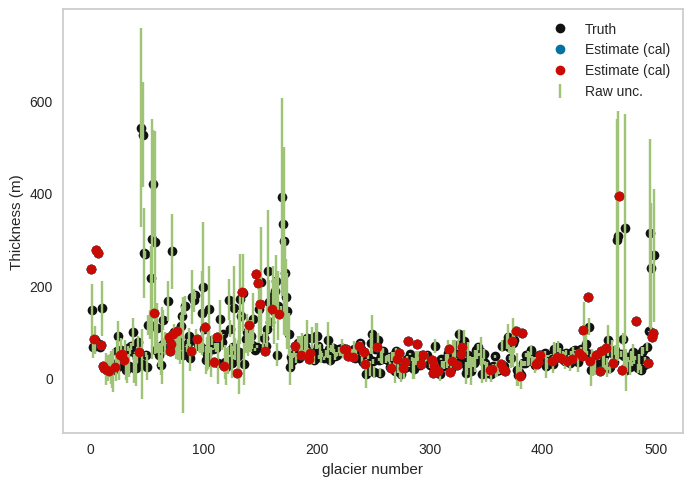

In [14]:
import matplotlib.pyplot as plt
plt.subplots()

plt.plot(thickness_true,'ok',label='Truth')
plt.plot(cal_labels,'o',label='Estimate (cal)')
# plt.errorbar(np.arange(n_total)[idx],
#              cal_labels,
#              yerr=cal_unc*qhat,
#              ls='none',label='CP')
plt.errorbar(
    np.arange(n_total)[~idx],
    val_labels,
    yerr=val_unc,
    ls='none',
    label='Raw unc.'
)
plt.plot(cal_labels,'o',label='Estimate (cal)')

# plt.plot(np.arange(n_total)[~idx],val_pred,'o',label='Estimate (val)')
plt.xlabel('glacier number')
plt.ylabel('Thickness (m)')
plt.legend()
plt.grid()
plt.show()

In [5]:
import numpy as np

n_total = 500
mu = 100
sigma = 10
# thickness_true = np.random.default_rng().normal(mu, sigma, n_total)
# thickness_estimates = np.random.default_rng().normal(mu, sigma, n_total)
# # thickness_uncertainty_estimates = np.random.default_rng().normal(2*sigma, 3*sigma, n_total)
# thickness_uncertainty_estimates = np.abs(thickness_true - thickness_estimates)

labels = df_g['Thickness']
predictions = df['Weighted Mean Thickness']
uncertainties = df['Weighted Deviation Uncertainty']

# Make splits (we wont randomly split because we will use Glathida/non-Glathida)
# n = 5 # number of calibration points
# idx = np.array([1] * n + [0] * (labels.shape[0]-n)) > 0
# np.random.shuffle(idx)
# cal_labels, val_labels = labels[idx], labels[~idx]
# cal_pred,   val_pred   = predictions[idx], predictions[~idx]
# cal_unc,    val_unc    = uncertainties[idx], uncertainties[~idx]

cal_labels = df_g['Thickness']
cal_pred = df_g['Weighted Mean Thickness']
cal_unc = df_g['Weighted Deviation Uncertainty']

def conformal_prediction(cal_labels,cal_pred,cal_unc, alpha = .05):
    n = cal_labels.shape[0]
    
    # Get scores
    cal_scores = np.abs(cal_pred - cal_labels)/cal_unc

    # Get the score quantile
    qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
    
    return qhat
qhat = conformal_prediction(cal_labels,cal_pred,cal_unc)
print(qhat)


0.1977130623063678


In [6]:
prediction_sets = [val_pred - val_unc*qhat, val_pred + val_unc*qhat ]

In [18]:
val_pred

1       90.268711
2       89.925246
4       51.614080
7       65.197201
8       67.835971
          ...    
492     58.174496
494     99.176178
495    107.120721
496     97.609065
499    121.197750
Name: Weighted Mean Thickness, Length: 400, dtype: float64

In [17]:
val_unc*qhat

1      112.771872
2       47.559202
4       60.401889
7       13.522774
8        3.649589
          ...    
492     17.543557
494      1.637614
495    407.264146
496    279.072605
499    285.853703
Length: 400, dtype: float64

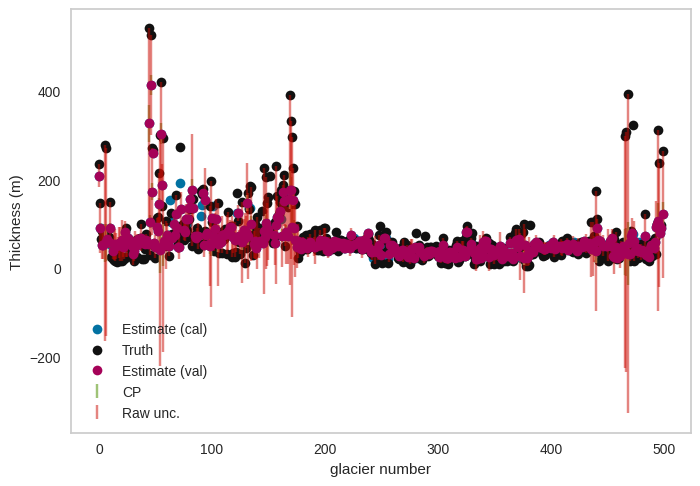

In [7]:
import matplotlib.pyplot as plt

plt.subplots()
plt.plot(thickness_estimates,'o',label='Estimate (cal)')
plt.plot(thickness_true,'ok',label='Truth')

plt.errorbar(np.arange(n_total)[~idx],val_pred,yerr=val_unc*qhat,ls='none',label='CP')
plt.errorbar(np.arange(n_total)[~idx],val_pred,yerr=thickness_uncertainty_estimates[~idx],
             ls='none',label='Raw unc.',alpha=0.5)

plt.plot(np.arange(n_total)[~idx],val_pred,'o',label='Estimate (val)')
plt.xlabel('glacier number')
plt.ylabel('Thickness (m)')
plt.legend(loc = 'best')
plt.grid()
plt.show()